# Stochastic Analysis

## load tables

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [36]:
agents_number_df = pd.read_csv('./agents_results.csv')
agents_number_df = agents_number_df.drop_duplicates(subset='damage')
agents_number_df = agents_number_df.loc[(agents_number_df['num_agents'] >= 100) &
    (agents_number_df['num_agents'] <= 500) & (agents_number_df['d'] == 5) & (agents_number_df['sigma'] == 1) & (
            agents_number_df['f'] == 1.5)]
agents_number_df = agents_number_df.groupby(['planner', 'num_agents'], as_index=False).mean()
agents_number_df.head()

,planner,num_agents,num_robots,f,d,sigma,active_time,planner_time,damage,num_disabled
0,StochasticAdditiveLackPlanner,100,5.0,1.5,5.0,1.0,267.268430,88.857599,23239.615267,59.018656
1,StochasticAdditiveLackPlanner,200,5.0,1.5,5.0,1.0,269.792252,932.109022,47371.664157,91.115900
2,StochasticAdditiveLackPlanner,300,5.0,1.5,5.0,1.0,268.868120,641.688411,71464.979522,116.644700
3,StochasticAdditiveLackPlanner,400,5.0,1.5,5.0,1.0,270.745241,1404.153019,96234.445304,135.973633
4,StochasticAdditiveLackPlanner,500,5.0,1.5,5.0,1.0,272.795413,2712.883743,120855.901135,155.023333


In [37]:
f_df = pd.read_csv('./f_results.csv')
f_df = f_df.drop_duplicates(subset='damage')
f_df = f_df.loc[(f_df['num_agents'] == 300) & (f_df['f'] < 2.6) & (f_df['num_robots'] == 5)]
f_df = f_df.groupby(['planner', 'f'], as_index=False).mean()
f_df.head()

,planner,f,num_agents,num_robots,d,sigma,active_time,planner_time,damage,num_disabled
0,StochasticAdditiveLackPlanner,1.5,300.0,5.0,5.0,1.0,270.276062,665.552661,71736.930662,116.50980
1,StochasticAdditiveLackPlanner,1.6,300.0,5.0,5.0,1.0,255.663112,894.768436,69524.902180,125.90300
2,StochasticAdditiveLackPlanner,1.7,300.0,5.0,5.0,1.0,241.953160,964.862926,67336.205637,132.62360
3,StochasticAdditiveLackPlanner,1.8,300.0,5.0,5.0,1.0,233.415275,987.132130,65510.113788,139.74850
4,StochasticAdditiveLackPlanner,1.9,300.0,5.0,5.0,1.0,222.656492,1011.817384,63734.306870,140.87825


In [38]:
robots_df = pd.read_csv('./robots_results.csv')
robots_df = robots_df.drop_duplicates(subset=['planner', 'damage'])
robots_df = robots_df.loc[(robots_df['f'] == 1.5)]
robots_df = robots_df.groupby(['planner', 'num_robots'], as_index=False).mean()
robots_df.head()

,planner,num_robots,num_agents,f,d,sigma,active_time,planner_time,damage,num_disabled
0,StochasticAdditiveLackPlanner,2,300.0,1.5,5.0,1.0,269.204154,230.472463,73667.118142,50.2700
1,StochasticAdditiveLackPlanner,3,300.0,1.5,5.0,1.0,266.137561,393.445509,72735.432604,73.0647
2,StochasticAdditiveLackPlanner,4,300.0,1.5,5.0,1.0,268.730211,499.841525,72285.799851,94.5646
3,StochasticAdditiveLackPlanner,5,300.0,1.5,5.0,1.0,270.861559,621.103033,71768.108023,115.1926
4,StochasticAdditiveLackPlanner,6,300.0,1.5,5.0,1.0,268.886984,780.834791,71044.220021,135.7784


## visualizations

In [39]:
planners_colors = {'StochasticIterativePlanner': 'red',
                   'StochasticStaticLackPlanner': 'blue',
                   'StochasticAdditiveLackPlanner': 'orange',
                   'StochasticMonotone15LackPlanner': 'green',
                   'StochasticMonotone20LackPlanner': 'purple',
                   'StochasticMonotone30LackPlanner': 'olive',
                   'StochasticMonotone45LackPlanner': 'cyan',
                   'StochasticMonotone60LackPlanner': 'pink'}

In [40]:
from typing import List


def visualize(X: List[str], Y: List[str], data, file_to_save: str, title: str):
    plt.figure(figsize=(14, 10))
    plt.suptitle(title, fontsize=18)

    for i in range(len(Y)):
        x, y = X[i], Y[i]

        plt.subplot(2, 2, i + 1)
        plt.xlabel(x)
        plt.ylabel(y)
        for j in range(len(data)):
            r = data[j]
            plt.plot(list(r[x]), list(r[y]), c=list(planners_colors.values())[j])

        if i == 1:
            plt.legend(planners_colors.keys(), fontsize='14')

    plt.savefig(file_to_save)
    plt.show()

In [41]:
def vis_paper(X: List[str], data):
    Y = ['damage', 'active_time', 'planner_time', 'num_disabled']

    for i in range(len(Y)):
        x = X[i]
        y = Y[i]

        plt.xlabel(x)
        plt.ylabel(y)
        for j in range(len(data)):
            r = data[j]
            plt.plot(list(r[x]),list(r[y]), c=list(planners_colors.values())[j])

        if i == 0:
            plt.legend(planners_colors.keys(), fontsize='14')

        plt.savefig(f'./plots/{x}-{y}.png')
        plt.show()

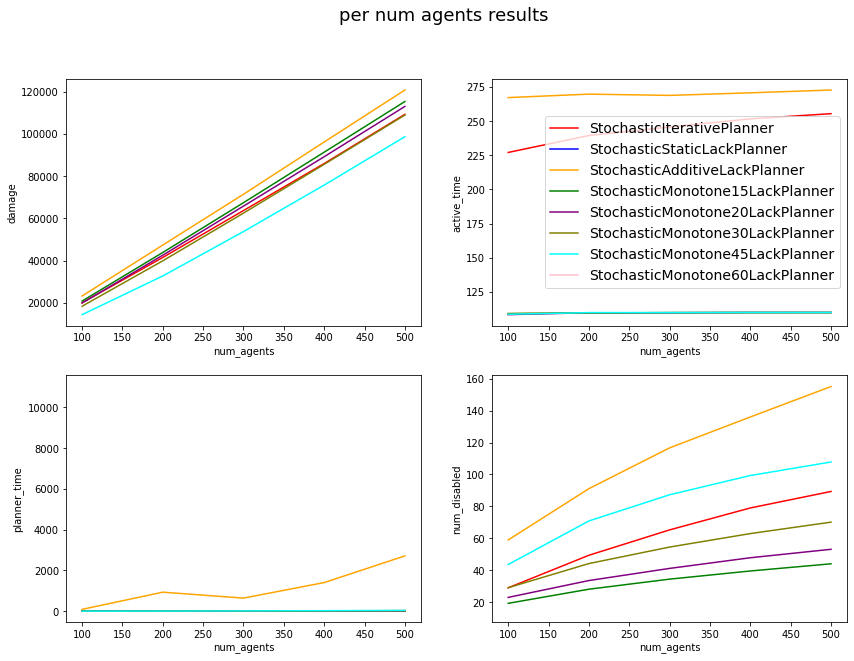

In [42]:
Y = ['damage', 'active_time', 'planner_time', 'num_disabled']
X = ['num_agents' for _ in Y]

agents_results = [agents_number_df.loc[agents_number_df['planner'] == name] for name in planners_colors.keys()]
title = 'per num agents results'
file_to_save = './plots/stochastic_num_agents.png'

visualize(X, Y, agents_results, file_to_save, title)

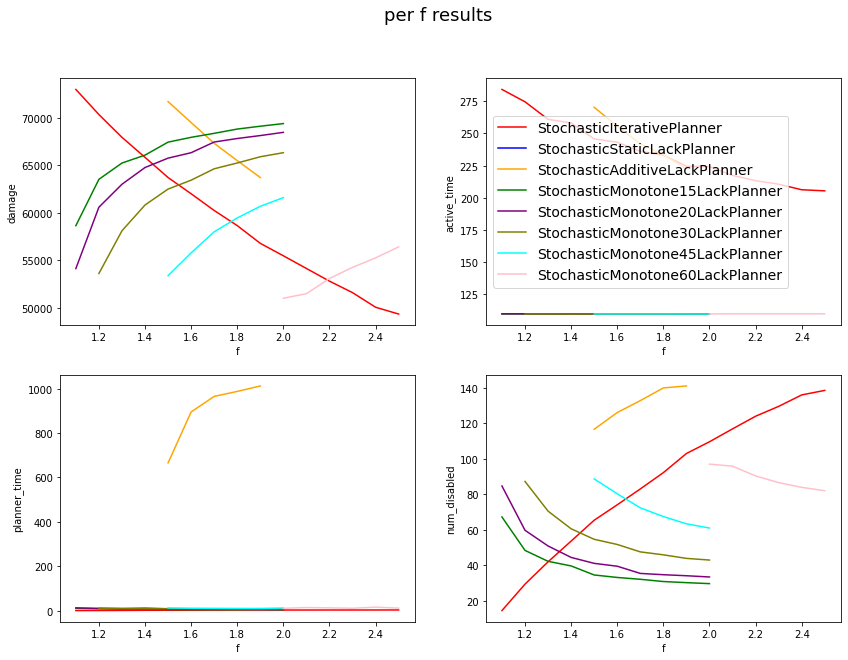

In [43]:
Y = ['damage', 'active_time', 'planner_time', 'num_disabled']
X = ['f' for _ in Y]

f_results = [f_df.loc[f_df['planner'] == name] for name in planners_colors.keys()]
title = 'per f results'
file_to_save = './plots/stochastic_f.png'

visualize(X, Y, f_results, file_to_save, title)

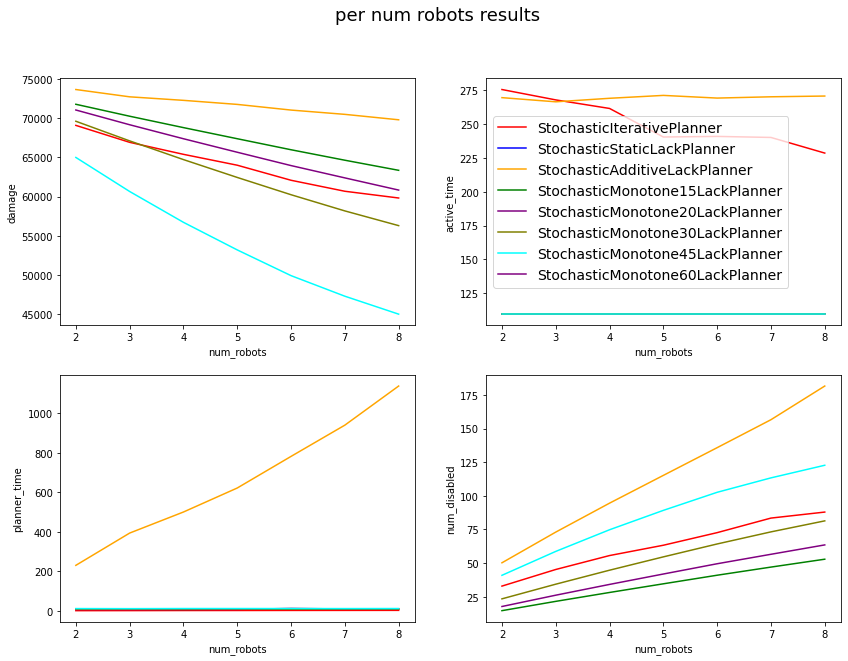

In [24]:
Y = ['damage', 'active_time', 'planner_time', 'num_disabled']
X = ['num_robots' for _ in Y]

robots_results = [robots_df.loc[robots_df['planner'] == name] for name in planners_colors.keys()]
title = 'per num robots results'
file_to_save = './plots/stochastic_num_robots.png'

visualize(X, Y, robots_results, file_to_save, title)

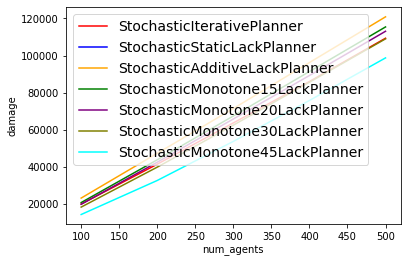

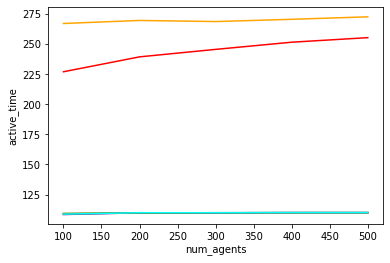

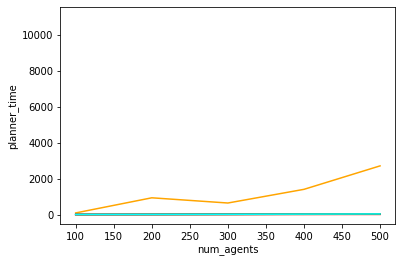

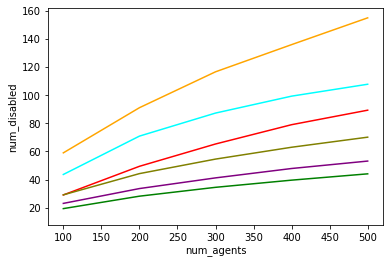

In [11]:
# agents_results = [agents_number_df.loc[agents_number_df['planner'] == name] for name in planners_colors.keys()]
# X = ['num_agents' for _ in Y]
# vis_paper(X, agents_results)

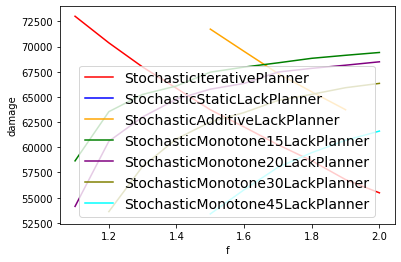

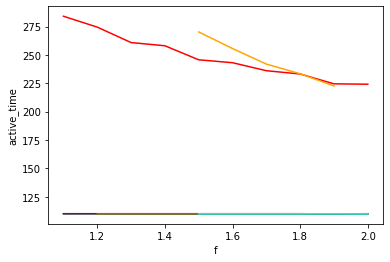

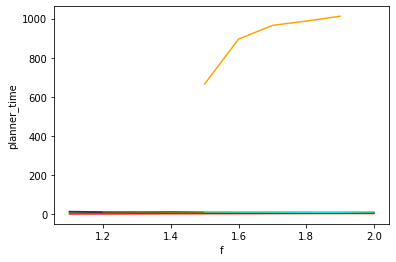

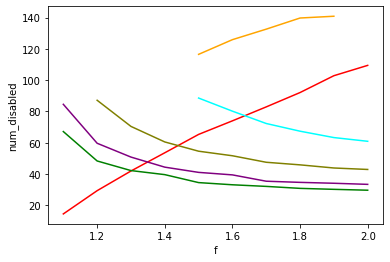

In [12]:
# f_results = [f_df.loc[f_df['planner'] == name] for name in planners_colors.keys()]
# X = ['f' for _ in Y]
# vis_paper(X, f_results)

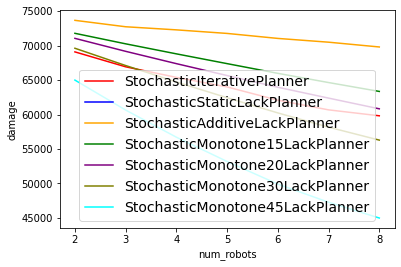

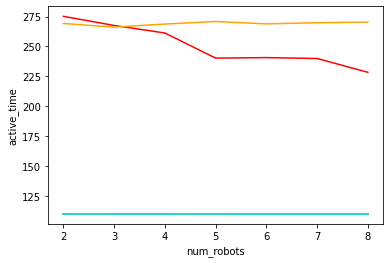

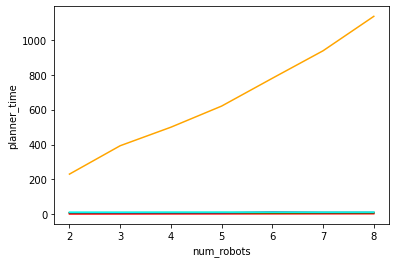

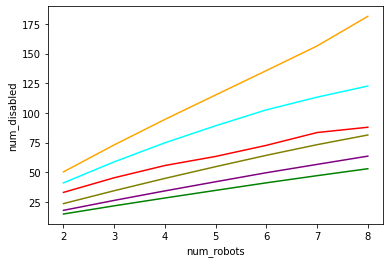

In [13]:
# robots_results = [robots_df.loc[robots_df['planner'] == name] for name in planners_colors.keys()]
# X = ['num_robots' for _ in Y]
# vis_paper(X, robots_results)

## run experiments

### config file

In [14]:
import json

with open('config.json') as json_file:
    config = json.load(json_file)
config
config['robot_speed'] = 1.2

In [15]:
import math
import time
from random import seed

from planners.stochastic.baseline.stochastic_iterative_planner import StochasticIterativePlanner
from planners.stochastic.partial_blockage.stochastic_additive_lack_planner import StochasticAdditiveLackPlanner
from planners.stochastic.partial_blockage.stochastic_monotone_lack_planner import StochasticMonotoneLackPlanner
from world.agents.stochastic_agent import StochasticAgent
from world.robots.timing_robot import TimingRobot
from world.stochastic_environment import StochasticEnvironment
from planners.planner import Planner
from planners.stochastic.partial_blockage.stochastic_static_lack_planner import StochasticStaticLackPlanner
from utils.functions import *

In [16]:
def run(planner: Planner, file_name: str):
    agents = [StochasticAgent(loc=sample_point(config['x_buffer'], config['x_buffer'] + config['x_size'],
                                               config['y_buffer'], config['y_buffer'] + config['y_size_init'], True),
                              v=config['agent_speed'], sigma=config['sigma']) for _ in range(config['num_agents'])]

    robots = [BasicRobot(sample_point(0, config['x_size'] + 2 * config['x_buffer'], 0, config['y_buffer'], True),
                         config['robot_speed'], config['disablement_range']) for _ in range(config['num_robots'])]

    env = StochasticEnvironment(agents=agents, robots=robots, top_border=config['y_size'] + config['y_buffer'],
                                right_border=config['x_size'] + config['x_buffer'], left_border=config['x_buffer'])

    before = time.time()
    _, active_time, expected_damage, expected_num_disabled = planner.plan(env)
    planning_time = time.time() - before

    write_report(planner=str(planner),
                 num_agents=config['num_agents'],
                 num_robots=config['num_robots'],
                 f=config['robot_speed'] / config['agent_speed'],
                 d=config['disablement_range'],
                 active_or_copmletion_time=active_time,
                 planner_time=planning_time,
                 damage=expected_damage,
                 num_disabled=expected_num_disabled,
                 file_name=file_name,
                 is_active_time=True,
                 sigma=config['sigma'])

In [17]:
planners = [StochasticMonotoneLackPlanner()]

for planner in planners:
    for alpha in [math.pi / 3]:
        planner.alpha = alpha
        for v in tqdm([100, 200, 300, 400, 500]):
            print(f'*** *** v={v} *** ***')
            for s in range(5):
                seed(s)

                config['num_agents'] = v
                print(f'running {str(planner)} with seed {s}..')
                try:
                    run(planner, 'agents_results.csv')
                except:
                    print('pass')

100%|██████████| 5/5 [00:00<00:00, 44.90it/s]

*** *** v=100 *** ***
running StochasticMonotone60LackPlanner with seed 0..
pass
running StochasticMonotone60LackPlanner with seed 1..
pass
running StochasticMonotone60LackPlanner with seed 2..
pass
running StochasticMonotone60LackPlanner with seed 3..
pass
running StochasticMonotone60LackPlanner with seed 4..
pass
*** *** v=200 *** ***
running StochasticMonotone60LackPlanner with seed 0..
pass
running StochasticMonotone60LackPlanner with seed 1..
pass
running StochasticMonotone60LackPlanner with seed 2..
pass
running StochasticMonotone60LackPlanner with seed 3..
pass
running StochasticMonotone60LackPlanner with seed 4..
pass
*** *** v=300 *** ***
running StochasticMonotone60LackPlanner with seed 0..
pass
running StochasticMonotone60LackPlanner with seed 1..
pass
running StochasticMonotone60LackPlanner with seed 2..
pass
running StochasticMonotone60LackPlanner with seed 3..
pass
running StochasticMonotone60LackPlanner with seed 4..
pass
*** *** v=400 *** ***
running StochasticMonotone6

In [ ]:
# planners = [StochasticMonotoneLackPlanner(), StochasticIterativePlanner(), StochasticStaticLackPlanner(),
#             StochasticAdditiveLackPlanner()]
planners = [StochasticAdditiveLackPlanner()]

config['num_agents'] = 300

for planner in planners:
    # for alpha in [math.pi / 3, math.pi / 4, math.pi / 6, math.pi / 9, math.pi / 12]:
    #     planner.alpha = alpha
    for v in tqdm([2.1, 2.2, 2.3, 2.4, 2.5]):
        print(f'*** *** v={v} *** ***')
        for s in range(30):
            seed(s)

            config['robot_speed'] = v
            print(f'running {str(planner)} with seed {s}..')
            try:
                run(planner, 'f_results.csv')
            except:
                print('pass')

  0%|          | 0/5 [00:00<?, ?it/s]

*** *** v=2.1 *** ***
running StochasticAdditiveLackPlanner with seed 0..
running StochasticAdditiveLackPlanner with seed 1..
running StochasticAdditiveLackPlanner with seed 2..
running StochasticAdditiveLackPlanner with seed 3..
running StochasticAdditiveLackPlanner with seed 4..
running StochasticAdditiveLackPlanner with seed 5..


In [15]:
planners = [StochasticMonotoneLackPlanner()]

config['num_agents'] = 300

for planner in planners:
    for alpha in [math.pi / 3]:
        planner.alpha = alpha
        for v in tqdm([2, 3, 4, 5, 6, 7, 8]):
            print(f'*** *** v={v} *** ***')
            for s in range(5):
                seed(s)

                config['num_robots'] = v
                print(f'running {str(planner)} with seed {s}..')
                run(planner, 'robots_results.csv')

  0%|          | 0/7 [00:00<?, ?it/s]

*** *** v=2 *** ***
running StochasticAdditiveLackPlanner with seed 0..
running StochasticAdditiveLackPlanner with seed 1..
running StochasticAdditiveLackPlanner with seed 2..
running StochasticAdditiveLackPlanner with seed 3..
running StochasticAdditiveLackPlanner with seed 4..
running StochasticAdditiveLackPlanner with seed 5..
running StochasticAdditiveLackPlanner with seed 6..
running StochasticAdditiveLackPlanner with seed 7..
running StochasticAdditiveLackPlanner with seed 8..
running StochasticAdditiveLackPlanner with seed 9..


 14%|█▍        | 1/7 [38:24<3:50:28, 2304.79s/it]

*** *** v=3 *** ***
running StochasticAdditiveLackPlanner with seed 0..
running StochasticAdditiveLackPlanner with seed 1..
running StochasticAdditiveLackPlanner with seed 2..
running StochasticAdditiveLackPlanner with seed 3..
running StochasticAdditiveLackPlanner with seed 4..
running StochasticAdditiveLackPlanner with seed 5..
running StochasticAdditiveLackPlanner with seed 6..
running StochasticAdditiveLackPlanner with seed 7..
running StochasticAdditiveLackPlanner with seed 8..
running StochasticAdditiveLackPlanner with seed 9..


 29%|██▊       | 2/7 [1:43:59<4:31:57, 3263.49s/it]

*** *** v=4 *** ***
running StochasticAdditiveLackPlanner with seed 0..
running StochasticAdditiveLackPlanner with seed 1..
running StochasticAdditiveLackPlanner with seed 2..
running StochasticAdditiveLackPlanner with seed 3..
running StochasticAdditiveLackPlanner with seed 4..
running StochasticAdditiveLackPlanner with seed 5..
running StochasticAdditiveLackPlanner with seed 6..
running StochasticAdditiveLackPlanner with seed 7..
running StochasticAdditiveLackPlanner with seed 8..
running StochasticAdditiveLackPlanner with seed 9..


 43%|████▎     | 3/7 [3:07:17<4:30:22, 4055.72s/it]

*** *** v=5 *** ***
running StochasticAdditiveLackPlanner with seed 0..
running StochasticAdditiveLackPlanner with seed 1..
running StochasticAdditiveLackPlanner with seed 2..
running StochasticAdditiveLackPlanner with seed 3..
running StochasticAdditiveLackPlanner with seed 4..
running StochasticAdditiveLackPlanner with seed 5..
running StochasticAdditiveLackPlanner with seed 6..
running StochasticAdditiveLackPlanner with seed 7..
running StochasticAdditiveLackPlanner with seed 8..
running StochasticAdditiveLackPlanner with seed 9..


 57%|█████▋    | 4/7 [4:50:48<4:05:19, 4906.65s/it]

*** *** v=6 *** ***
running StochasticAdditiveLackPlanner with seed 0..
running StochasticAdditiveLackPlanner with seed 1..
running StochasticAdditiveLackPlanner with seed 2..
running StochasticAdditiveLackPlanner with seed 3..
running StochasticAdditiveLackPlanner with seed 4..
running StochasticAdditiveLackPlanner with seed 5..
running StochasticAdditiveLackPlanner with seed 6..
running StochasticAdditiveLackPlanner with seed 7..
running StochasticAdditiveLackPlanner with seed 8..
running StochasticAdditiveLackPlanner with seed 9..


 71%|███████▏  | 5/7 [7:00:57<3:18:26, 5953.06s/it]

*** *** v=7 *** ***
running StochasticAdditiveLackPlanner with seed 0..
running StochasticAdditiveLackPlanner with seed 1..
running StochasticAdditiveLackPlanner with seed 2..
running StochasticAdditiveLackPlanner with seed 3..
running StochasticAdditiveLackPlanner with seed 4..
running StochasticAdditiveLackPlanner with seed 5..
running StochasticAdditiveLackPlanner with seed 6..
running StochasticAdditiveLackPlanner with seed 7..
running StochasticAdditiveLackPlanner with seed 8..
running StochasticAdditiveLackPlanner with seed 9..


 86%|████████▌ | 6/7 [9:37:24<1:58:40, 7120.53s/it]

*** *** v=8 *** ***
running StochasticAdditiveLackPlanner with seed 0..
running StochasticAdditiveLackPlanner with seed 1..
running StochasticAdditiveLackPlanner with seed 2..
running StochasticAdditiveLackPlanner with seed 3..
running StochasticAdditiveLackPlanner with seed 4..
running StochasticAdditiveLackPlanner with seed 5..
running StochasticAdditiveLackPlanner with seed 6..
running StochasticAdditiveLackPlanner with seed 7..
running StochasticAdditiveLackPlanner with seed 8..
running StochasticAdditiveLackPlanner with seed 9..


100%|██████████| 7/7 [12:46:46<00:00, 6572.36s/it] 
